<a href="https://colab.research.google.com/github/KeishiIrisa/deeplearning-basic/blob/main/lecture06_exercise_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第6回講義 演習

今回は，FCN（Fully Convolutional Network）を実装し，VOC2011データセットにSegmentationを実行します．



## 目次
[【課題】FCNによる segmentation モデルの実装と学習](#scrollTo=_pBFN4mD934j)
1. [VOC2011 データセットの読み込みと可視化](#scrollTo=d304y5XwRvGG)
2. [Preprocessing](#scrollTo=Lamm5y2CT2-W)
3. [FCN の実装](#scrollTo=R2yHHDp0VUJR)

  3.1 [backbone （事前学習モデル） の利用](#scrollTo=k4regropVqgq)

  3.2 [FCN クラスの実装](#scrollTo=KHaV8k4mXrHm)

4. [FCN の学習](#scrollTo=igJrjMAjasf_)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import VOCSegmentation

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 【課題】FCNによる segmentation モデルの実装と学習

## 1.VOC2011 データセットの読み込みと可視化

今回の演習で扱う**VOC2011**は，以下の3用途に用いることができる，画像認識タスク用のデータセットとなっています．
- Classification
- Segmentation
- Object detection

Segmentationタスク用には，以下が提供されています．
- 入力画像
- Segmentation mask（ピクセル単位/21クラス）

VOC2011 を 前回の CIFAR-10 と同様，PyTorch でダウンロードし描画します．

以下では入力画像が左，Segmentation maskが右です．

100%|██████████| 1.77G/1.77G [00:28<00:00, 62.6MB/s]


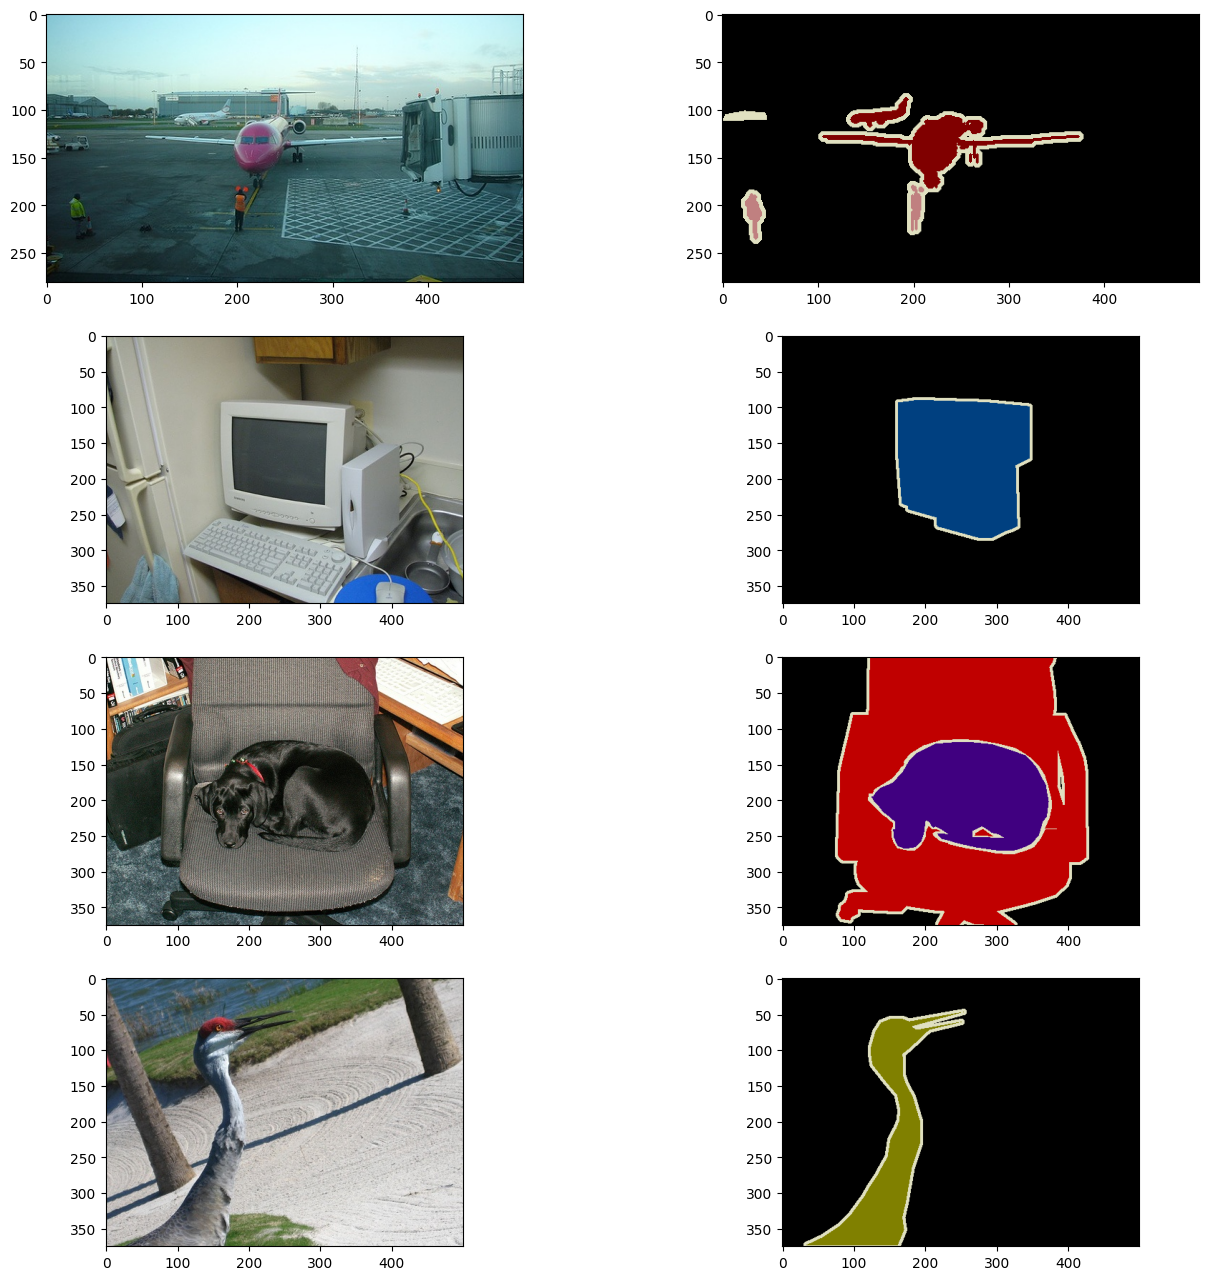

In [2]:
#　VOC2011の可視化
train_dataset = VOCSegmentation(root="./VOCSegmentation/2011",
                                   year="2011", image_set="train", download=True)

plt.figure(figsize=(16, 16))
for i in range(4):
    image, target = train_dataset[i]
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(image);
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(target);

## 2.Preprocessing
VOCデータセットに以下の前処理を施します
- 入力画像，segmentation mask ともに(224, 224)へのリサイズ
- segmentation mask の境界線に対応するクラス(255)の除去
- クラスラベルのone-hot encoding

前処理により，それぞれ以下のような形状になります．
- 入力画像: (3, 224, 224)
- segmentation mask: (21, 224, 224)

本演習では PyTorch に用意されている前処理の中でも画像サイズの変更 (Resize) ，PyTorch の Tensor クラスへの変更と正規化 (ToTensor) のみを利用していますが， PyTorch では様々な前処理が用意されています．以下の公式リファレンスを参考にしてください．
https://pytorch.org/vision/main/transforms.html#v1-api-reference  

In [3]:
batch_size = 16
num_classes = 21

# 前処理の定義
def TargetToTensor(target):
    target = np.array(target)
    target[target > 20] = 0 # labelを0-20の合計21クラスに限定（objectのエッジを消す）
    target = torch.from_numpy(target).type(torch.long)
    target = F.one_hot(target, num_classes=num_classes).permute(2,0,1).type(torch.float)
    return target  # (21, 224, 224)

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # (224, 224) にリサイズ
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda target: TargetToTensor(target))
])

# datasetの定義
train_dataset = VOCSegmentation(root="./VOCSegmentation/2011", year="2011",
                                image_set="train", download=True,
                                transform=image_transform,
                                target_transform=target_transform)
valid_dataset = VOCSegmentation(root="./VOCSegmentation/2011", year="2011",
                                image_set="val", download=True,
                                transform=image_transform,
                                target_transform=target_transform)

# dataloaderの定義
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## 3.FCNの実装

FCNは以下の二段階に分かれます．
- 既存の画像認識モデル（backbone）による特徴抽出
- ConvolutionとUpscaleによるピクセル単位の予測

### 3.1 backbone（事前学習モデル）の利用

今回はbackboneとして以下の事前学習モデルを採用します．
- ResNet18

<img src="https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png" alt="ResNet18" width=600 >

https://www.researchgate.net/publication/336642248_A_Deep_Learning_Approach_for_Automated_Diagnosis_and_Multi-Class_Classification_of_Alzheimer's_Disease_Stages_Using_Resting-State_fMRI_and_Residual_Neural_Networks

- GAP層（Global Average Pooling層）とFC層を外し，特徴抽出器とする


 backboneの入出力(CHW)は以下のようになります．
 - 入力: (3, 224, 224)
 - 出力: (512, 7, 7)


 PyTorch では様々な事前学習モデルが実装されています．タスクの複雑さやダウンストリームとの相性，利用可能な計算資源に応じて使い分けることが可能です．

 参考: https://pytorch.org/vision/main/models.html

In [6]:
# backbone の作成
# resnet18 = torchvision.models.resnet18(pretrained=torchvision.models.ResNet18_Weights.DEFAULT)
# resnet18 = nn.Sequential(*list(resnet18.children())[:-2])  # GAP層とFC層を外す
resnet18 = torchvision.models.resnet18(pretrained=torchvision.models.ResNet18_Weights.DEFAULT)
resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

# backbone の出力サイズを確認
dummy = torch.rand(1, 3, 224, 224)  # (B, C, H, W)
resnet18(dummy).shape

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512, 7, 7])

### 3.2 FCNクラスの実装
FCNでは，以下の手順で予測を出力します．
- Convolution: backboneで得られた特徴をクラス数のchannelに変換
- Upscale: スケールが元画像に一致するよう変換して，予測とする

今回はそれぞれを以下のように実装します．
- Convolution: FCNhead
  - Conv2d(input_channel, input_channel//4, 3, padding=1, bias=False)
  - BatchNorm2d
  - ReLU
  - Dropout(0.1)
  - Conv2d(input_channel//4, num_classes, 1)
- Upscale: `F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)`

In [10]:
# FCNの定義
# class FCN(nn.Module):
#     def __init__(self, backbone, num_classes=21):
#         super(FCN, self).__init__()
#         # backbone
#         self.backbone = backbone
#         # convolution
#         self.FCNhead = nn.Sequential(nn.Conv2d(512, 128, 3, padding=1, bias=False),
#                                       nn.BatchNorm2d(128),
#                                       nn.ReLU(),
#                                       nn.Dropout(0.1),
#                                       nn.Conv2d(128, num_classes, 1))  # WRITE ME

#     def forward(self, x):
#         input_shape = x.shape[-2:]  # shape: (224, 224)
#         x = self.backbone(x)  # WRITE ME # (512, 7, 7)
#         x = self.FCNhead(x)  # WRITE ME # (21, 7, 7)
#         x = F.interpolate(
#             x,
#             size=input_shape,
#             mode='bilinear',
#             align_corners=False
#             )  # WRITE ME # upscale (21, 224, 224)
#         return x

class FCN(nn.Module):
  def __init__(self, backbone, num_classes=21):
    super().__init__()
    # backbone
    self.backbone = backbone
    # convolution
    self.FCNhead = nn.Sequential(
        nn.Conv2d(512, 128, 3, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Conv2d(128, num_classes, 1)
    )

  def forward(self, x):
    input_shape = x.shape[-2:]
    x = self.backbone(x)
    x = self.FCNhead(x)
    x = F.interpolate(
        x,
        size=input_shape,
        mode='bilinear',
        align_corners=False
    )
    return x


## 4.FCNの学習

以上に実装したFCNを，VOCデータセットに対して学習させます．

In [ ]:
# modelの作成
model = FCN(backbone=resnet18, num_classes=num_classes)
model.to(device)

以下のように設定します．
- オプティマイザ: AdamW
- 損失関数: BinaryCrossEntropy
- 評価指標: mean-IoU

<img src="https://learnopencv.com/wp-content/uploads/2022/08/05-document-segmentation-IoU-Dice-concept.png" alt="miou" width=600 >

https://learnopencv.com/deep-learning-based-document-segmentation-using-semantic-segmentation-deeplabv3-on-custom-dataset/


In [ ]:
# 下記リンク先のmIoU実装を利用
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/utils.py
class mIoUScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)    # ij 成分は，target がクラス i ， 予測がクラス j だったピクセルの数
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        hist = self.confusion_matrix
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iou = np.nanmean(iou)
        return mean_iou

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

In [ ]:
# optimizer, loss function, metricsの定義
loss_fn = nn.BCEWithLogitsLoss()  # WRITE ME
metrics = mIoUScore(num_classes)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

 FCNの学習を実行します．  
 google colab の無料枠で数分で終わります．

In [ ]:
n_epochs = 5

# modelの学習
for epoch in range(n_epochs):
    train_losses = []
    valid_losses = []
    metrics.reset()

    model.train()
    with tqdm(total=len(train_dataloader), unit="batch") as pbar:
        pbar.set_description(f"[train] Epoch {epoch+1}/{n_epochs}")
        for image, target in train_dataloader:
            optimizer.zero_grad()
            image, target = image.to(device), target.to(device)
            output = model(image)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            pbar.set_postfix(loss=np.array(train_losses).mean())
            pbar.update(1)

    model.eval()
    with tqdm(total=len(valid_dataloader), unit="batch") as pbar:
        pbar.set_description(f"[valid] Epoch {epoch+1}/{n_epochs}")
        for image, target in valid_dataloader:
            image, target = image.to(device), target.to(device)
            output = model(image)
            loss = loss_fn(output, target)
            valid_losses.append(loss.item())
            metrics.update(target.argmax(1).cpu().numpy(), output.argmax(1).cpu().numpy())
            pbar.set_postfix(loss=np.array(valid_losses).mean(), mIoU=metrics.get_scores())
            pbar.update(1)

学習が終わったら，FCNによる予測を確認してみましょう．
- 左列: 元画像
- 中列: 予測
- 右列: 正解

In [ ]:
# 予測の可視化
plt.figure(figsize=(12, 16))
model.eval()
for i in range(4):
    image, target = valid_dataset[i]
    pred = model(image.to(device).unsqueeze(0))
    plt.subplot(4, 3, 3*i+1)
    plt.title("image")
    plt.imshow(image.numpy().transpose(1,2,0));
    plt.subplot(4, 3, 3*i+2)
    plt.title("pred")
    plt.imshow(pred.argmax(1).cpu().numpy()[0]);
    plt.subplot(4, 3, 3*i+3)
    plt.title("gt")
    plt.imshow(target.argmax(0).cpu().numpy());